<a href="https://colab.research.google.com/github/cukelarter/HCP-fMRI-Analysis/blob/main/Analyzing_HCP_fMRI_Data_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data 
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [2]:
# @title Install dependencies
!pip install nilearn --quiet

     |████████████████████████████████| 9.6 MB 2.3 MB/s 


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [6]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [7]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [8]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Example WM / Testing

Archived testing used during development.

In [ ]:
my_exp = 'WM'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


lf_activity = average_frames(data, evs, my_exp, '0bk_body')
rf_activity = average_frames(data, evs, my_exp, '2bk_body')
contrast = lf_activity - rf_activity  # difference between left and right hand movement

In [ ]:
EXPERIMENTS['WM']['cond'].index('0bk_faces')
evs
lf_activity.shape

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='baseline')
plt.plot(rf_activity,label='2-Back')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, '0bk_body')
    rf_activity = average_frames(data, evs, my_exp, '2bk_body')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

In [ ]:
plt.plot(lf_activity)
plt.plot(rf_activity)
plt.show()

## Archived Testing

Ignore this! or don't

In [ ]:
exp='WM' 
task='0bk_faces'
r=0
data = load_single_timeseries(subject=s, experiment=exp,run=r, remove_mean=True)
evs = load_evs(subject=s, experiment=exp,run=r)
activity=average_frames(data, evs, exp, task)
a=np.empty((200,360))
a[:,1]=activity
#a[:,2]
a.shape
a[150]

In [ ]:
taskData['0bk_body'].shape
(taskData[task] for task in tasks)

In [ ]:
a = np.append(taskData['0bk_body'],taskData['2bk_body'], axis=1)
a.shape

In [ ]:
np.concatenate((taskData['0bk_body'],taskData['2bk_body']),axis=1).shape

In [ ]:

data = load_single_timeseries(subject=s, experiment=exp,run=r, remove_mean=True)
evs = load_evs(subject=s, experiment=exp,run=r)
activity=average_frames(data, evs, exp, task)
plt.plot(activity)

In [ ]:
# lets get the feature matrix!
def getData(tasks,exp='WM'):
  """
  Returns task all subject data for defined tasks and experiments
  Args:
    tasks (list of str)   : list of tasks for which data is collected
  Returns:
    taskData (dictionary) : average frame data for each participant task=key
  """
  #taskData=dict.fromkeys(tasks,np.empty((360,200)))
  taskData=dict.fromkeys(tasks,np.empty((200,360)))
  ii=0
  for s in subjects:
    for r in [0, 1]:
      data = load_single_timeseries(subject=s, experiment=exp,
                                    run=r, remove_mean=True)
      evs = load_evs(subject=s, experiment=exp,run=r)
      # cycle through each relevant task and append to out dict
      for task in tasks:

### THIS IS THE PART THAT DOESN'T WORK!!!z
        activity=average_frames(data, evs, exp, task)
        #np.concatenate([taskData[task], activity], axis=0)
        taskData[task][ii]=activity
        plt.plot(activity)
      ii+=1
      break
    break
  plt.show()
  return taskData

tasks=['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']
taskData=getData(tasks)

def combineParadigms(taskData,tasks):
  """
  Quick helper to combine task data from different tasks
  """
  return np.concatenate([taskData[task] for task in tasks],axis=0)

# combine paradigms across all tasks
X_all=combineParadigms(taskData,tasks)

# separate paradigms by baseline vs 2_bk
X_base = combineParadigms(taskData,tasks=['0bk_body','0bk_faces','0bk_places','0bk_tools'])
X_2bk  = combineParadigms(taskData,tasks=['2bk_body','2bk_faces','2bk_places','2bk_tools'])

# Necessary Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Extracting Feature Matrix

In [10]:
# Data Formatting - End goal of having X feature vector of shape (N,R) N=samples R=regions of interest (360)
# Samples should be averaged to factor out the time dimension 
    # They do it above, and I have no idea how else to shape the data otherwise
# ? How do we restrict which trial types to look at, or combine them into the same set
    # ? Should covariance be calculated across whole data set (base+2_bk) or one each
      # maybe try both and see idk something man

In [11]:
# took this from above because I don't wanna have to find it later
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

def average_task(experiment,tasks,subject):
  """Averages data across both runs and on specified tasks and subject.
  """
  return np.mean([average_frames(load_single_timeseries(subject=subject, experiment=experiment,
          run=r, remove_mean=True), load_evs(subject=subject, experiment=exp,run=r),
          exp, task) for r in [0,1] for task in tasks], axis=0)
  

In [12]:
# Task Parameters - WM 0bk task vs 2bk task
exp='WM'
tasks_0=['0bk_body','0bk_faces','0bk_places','0bk_tools']#,'2bk_body','2bk_faces','2bk_places','2bk_tools']
tasks_2=['2bk_body','2bk_faces','2bk_places','2bk_tools']
#subj='103818'

X_0bk = np.array([average_task(exp,tasks_0,subj) for subj in subjects])
X_2bk = np.array([average_task(exp,tasks_2,subj) for subj in subjects])

In [25]:
# Task Parameters - WM tools vs others
exp='WM'
tasks_0=['0bk_body','0bk_faces','0bk_places','2bk_body','2bk_faces','2bk_places']#,'2bk_body','2bk_faces','2bk_places','2bk_tools']
tasks_2=['0bk_tools','2bk_tools']
#subj='103818'

X_0bk = np.array([average_task(exp,tasks_0,subj) for subj in subjects])
X_2bk = np.array([average_task(exp,tasks_2,subj) for subj in subjects])

In [26]:
# set labels and combine
X_all = np.concatenate([X_0bk, X_2bk])
X_labels = np.array([i<X_all.shape[0]/2 for i in range(X_all.shape[0])])
X_all.shape

(200, 360)

# PCA - Principal Component Analysis
To do PCA on this data we need some things:
1. Calculate the eigenvectors of the sample covariance matrix.
2. Project data onto the eigenvectors

In [29]:
from sklearn.preprocessing import StandardScaler

X=X_all

# standard scaler is only applicable on data with a normal distribution ?
#scaler = StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)    

#calculate cov matrix - manually
n_samples=X.shape[0]
X_mean=np.mean(X, axis=0)

#X -= np.mean(X, axis=0)
sample_cov_matrix = np.dot(X.T, X) / n_samples

# calculate covariance matrix - builtin
#sample_cov_matrix=np.cov(X, rowvar=False)

evals,evectors = np.linalg.eigh(sample_cov_matrix) # calculate eigenvalues and eigenvectors

scores=np.matmul(X,evectors) # project onto basis

print(sample_cov_matrix)

[[556.75590667  94.24760866 158.1876954  ...  12.83676192 170.71334124
   49.84732952]
 [ 94.24760866  97.02033514  26.94359065 ...  -4.90390062  31.81278282
   26.02083763]
 [158.1876954   26.94359065 216.82041495 ...  58.58333485 103.26706614
   35.19182138]
 ...
 [ 12.83676192  -4.90390062  58.58333485 ... 172.33694331  79.42329309
   55.24851881]
 [170.71334124  31.81278282 103.26706614 ...  79.42329309 270.84500132
  128.93072591]
 [ 49.84732952  26.02083763  35.19182138 ...  55.24851881 128.93072591
  330.86879795]]


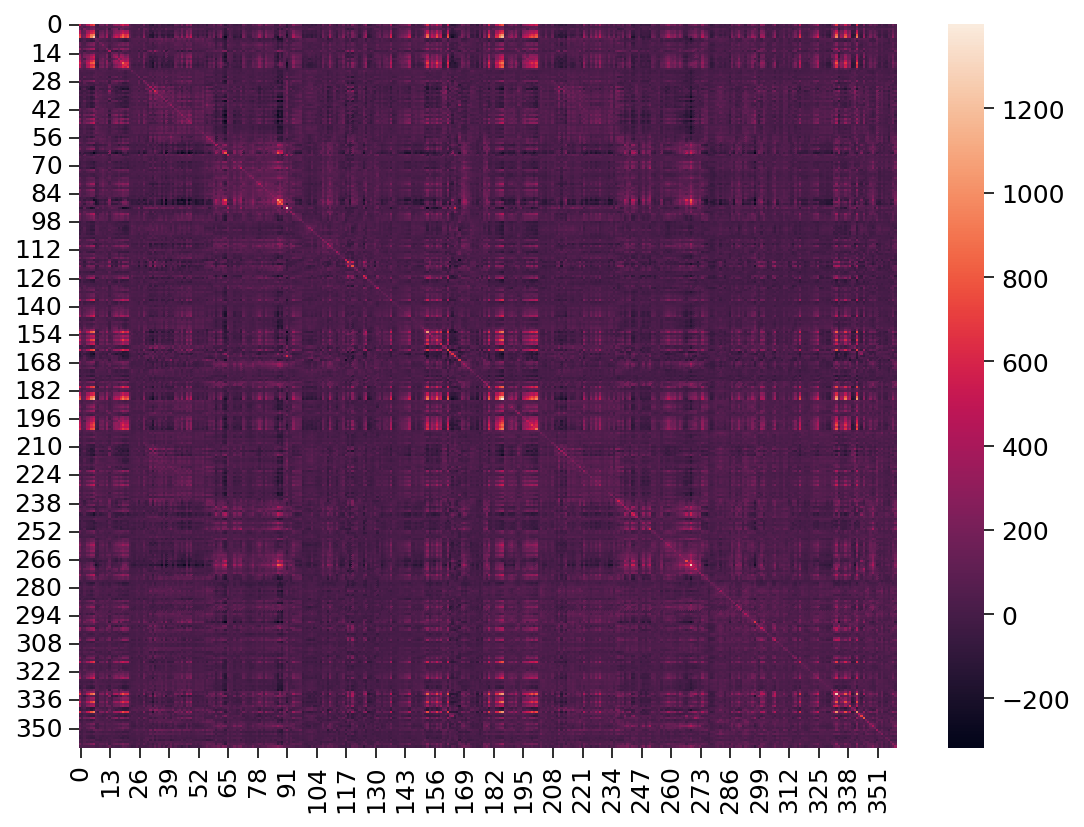

In [30]:
# simple visualization of covariance matrix
import seaborn as sns

sns.heatmap(sample_cov_matrix)

## Helper Functions

Most of these are unused in favor of built-ins (scikit, np, etc).


In [31]:
def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors

def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y

def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.

  Args:
    X (numpy array of floats): Data matrix each column corresponds to a
                               different random variable

  Returns:
    (numpy array of floats)  : Data projected onto the new basis
    (numpy array of floats)  : Vector of eigenvalues
    (numpy array of floats)  : Corresponding matrix of eigenvectors

  """

  # Calculate the sample covariance matrix
  cov_matrix = np.cov(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals,evectors)

  # Project the data onto the new eigenvector basis
  #score = change_of_basis(X,evectors)

  return evectors, evals
def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """

  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum/sum(evals)
  return variance_explained

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X-np.mean(X,axis=0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = np.matmul(X.T,X)/X.shape[0]

  return cov_matrix

### Plotting Functions

In [32]:
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()
  
def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

# PCA - Separate Components

In [33]:
from sklearn.decomposition import PCA

pca=PCA(0.9) # use this to automatically restrict components to n% variance explained (90% here)
#pca=PCA(n_components=360)
pca.fit(X, X_labels)

scores=pca.transform(X)
scores.shape


(200, 54)

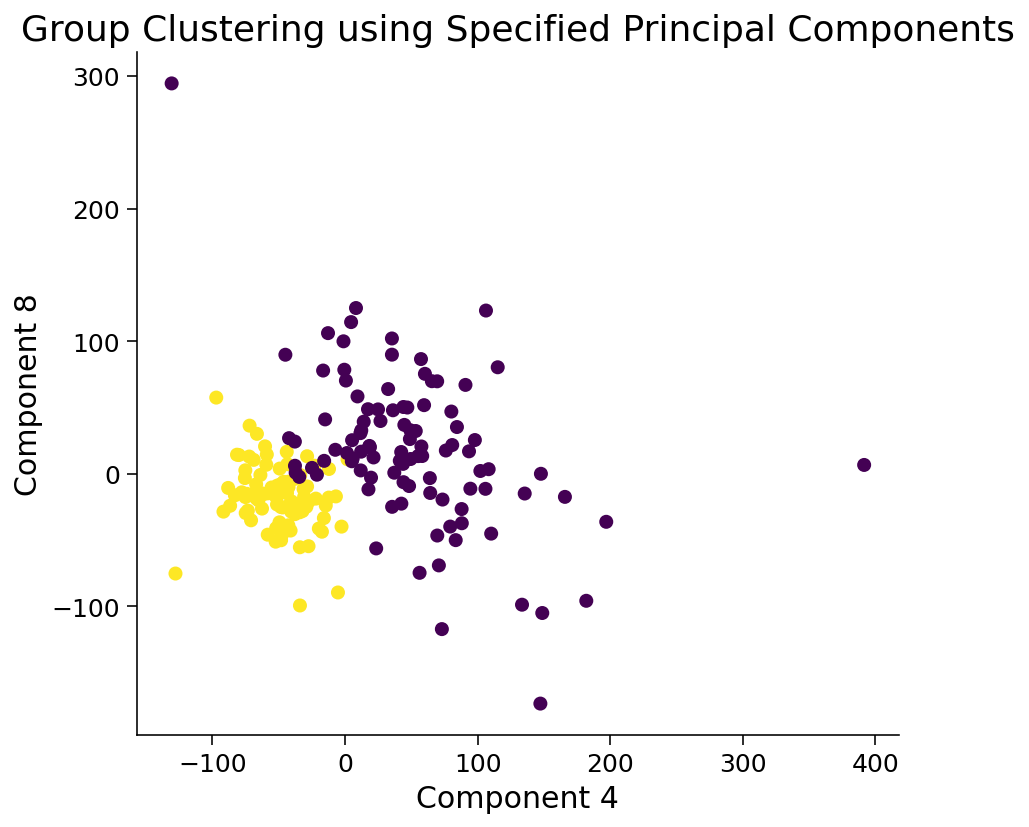

In [34]:
# visualize Specific component relationships
comp1=3
comp2=7
fig, ax = plt.subplots()
ax.set_title('Group Clustering using Specified Principal Components')
ax.scatter(scores[:,comp1],scores[:,comp2],c=X_labels) 
# yellow is 0-back, purple is 2-back
plt.xlabel(f'Component {comp1+1}')
plt.ylabel(f'Component {comp2+1}')
ax.set_aspect('equal')
plt.show() 

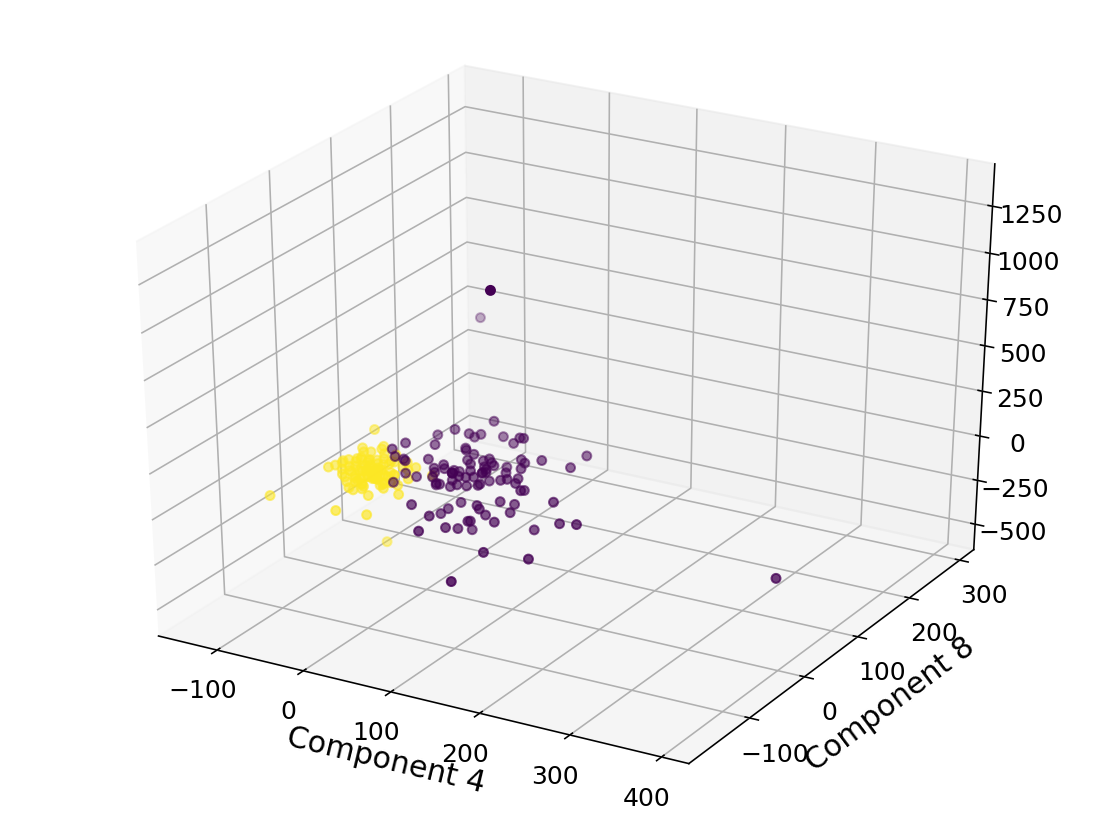

In [36]:
# replicate above in 3D
fig=plt.figure()
ax = plt.axes(projection="3d")
comps=[3,7,1]
ax.scatter3D(scores[:,comps[0]],scores[:,comps[1]], scores[:,comps[2]],c=X_labels);
plt.xlabel(f'Component {comps[0]+1}')
plt.ylabel(f'Component {comps[1]+1}')
#plt.zlabel(f'Component {comps[2]+1}')
plt.show()

https://sci-hubtw.hkvisa.net/10.1016/j.neuroimage.2017.06.068

**Conclusion**: Looking specifically at PC2 may give us some insight into what regions create this clustering.
 

## T-Test Individual Components
See if we can linearly separate the data, but do it in a way that doesn't have you looking at a million (58) different components visually instead of statistically.

In [35]:
from scipy import stats
component=1
compdata=scores[:,component]
for component in range(0,scores.shape[1]):
  compdata=scores[:,component]
  # split them by task type
  a=compdata[:int(len(compdata)/2)] # 0-back !
  b=compdata[int(len(compdata)/2):] # 2-back
  tStat, pValue = stats.ttest_ind(a, b) #run independent sample T-Test. can also use ttest_rel which highlights same components.
  if pValue<0.05:
    print(f'! Component {component+1} !')
    print(f"P-Value:{pValue} T-Statistic:{tStat}") #print the P-Value and the T-Statistic

! Component 1 !
P-Value:0.00017582168003141185 T-Statistic:-3.8240676564257865
! Component 3 !
P-Value:0.03998083360928811 T-Statistic:2.0675683437317662
! Component 4 !
P-Value:3.0281774339077923e-33 T-Statistic:-14.598472682477231
! Component 5 !
P-Value:0.014629298389135912 T-Statistic:-2.463065101052566
! Component 7 !
P-Value:0.011470933576160292 T-Statistic:2.5518158094536307
! Component 8 !
P-Value:3.2739124044424025e-08 T-Statistic:-5.753937601227036


**Conclusion**: PC2 has high significance with regards to t-test, and PC6 does as well. Generating 2D data using these two PCs shows data that is nearly linearly separable (1 point would generate an error).

## Linear Discriminate Analysis
Now that we have a 2D space that effectively segments our task groups, perform linear discriminate analysis.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
model = LinearDiscriminantAnalysis()
comp1=3
comp2=7
X_LDA=np.c_[scores[:,comp1],scores[:,comp2]]
# X is features, y prediction
model.fit(X_LDA, X_labels)

LinearDiscriminantAnalysis()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=69)
# evaluate model
cv_scores = cross_val_score(model, X_LDA, X_labels, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

Mean Accuracy: 0.938 (0.036)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, X_labels, test_size=0.2)
  
# apply Linear Discriminant Analysis
#X_train = model.fit_transform(X_train, y_train)
#X_test = model.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
# plot the scatterplot
#plt.scatter(
    #X_train[:,0],X_train[:,1],c=y_train,cmap='rainbow',
  #alpha=0.7,edgecolors='b'
#)
  
# classify using random forest classifier
classifier = RandomForestClassifier(max_depth=3)#, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
  
# print the accuracy and confusion matrix
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)

Accuracy : 1.0
[[21  0]
 [ 0 19]]


**Conclusion**: High accuracy acheived with just two principal components! Need to toy with LDA more and determine how to build into something reconstructable into our brain mapping.

## Data Reconstruction/Single Component Analysis

Visualize weights of components, specifically principal component 2.


In [37]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [38]:
evectors=pca.components_
comp=3      # 1 is of interest
# 3 and 7 are of interest in the context of tool stim
weights=evectors[comp,:]

In [55]:
evectors.shape

(54, 360)

In [39]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
#surf_contrast = group_contrast[atlas["labels_L"]]
surf_contrast= weights[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   title=f'Weights/Eigenvector of PC{comp+1}',
                   # use vmin and vmax to scale if necessary
                   #symmetric_cmap=False
                   )

## Explained Variance

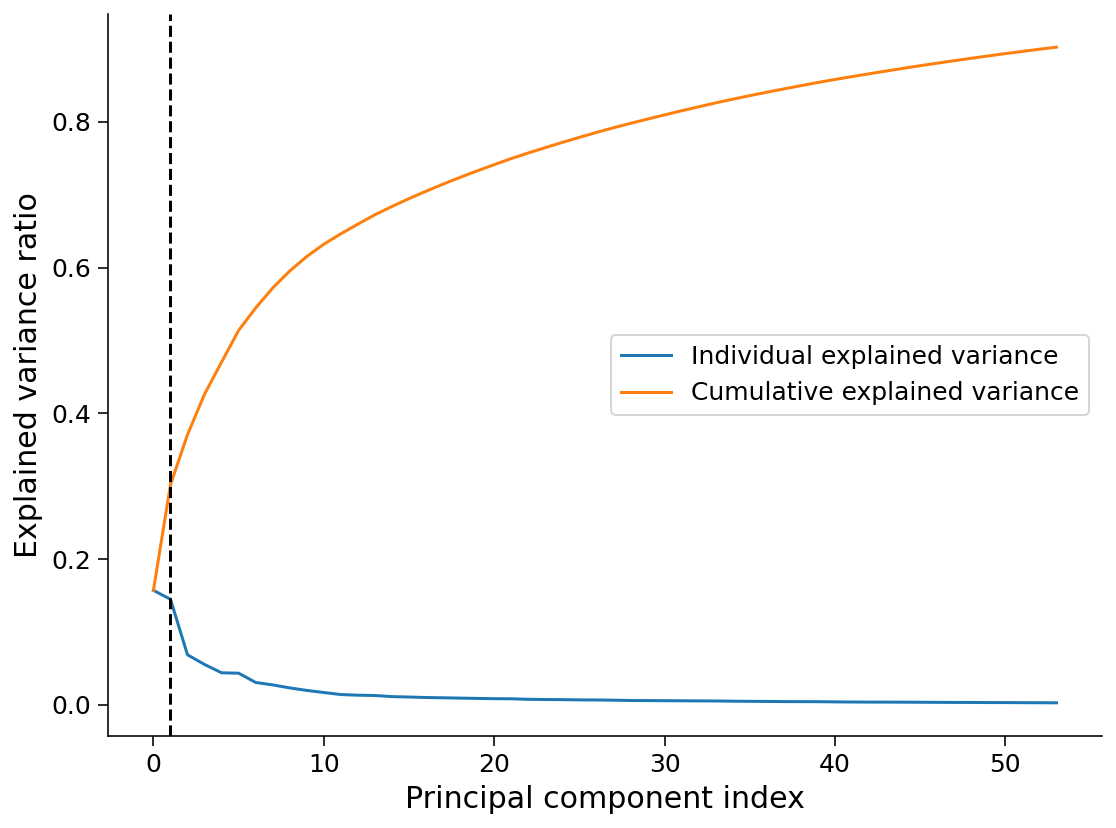

In [ ]:
# Visualize
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.plot(exp_var_pca,label='Individual explained variance')
plt.plot(cum_sum_eigenvalues, label='Cumulative explained variance')
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim(0,150)
#plt.axhline(0.9, linestyle='--', color='black') # mark 90% variance explained
plt.axvline(1, linestyle='--', color='black')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

#pca=PCA(0.9) # use this to automatically restrict components to n% variance explained (90% here)
pca_model=PCA(n_components=2)
principalComps = pca_model.fit(X)

scores=pca_model.transform(X)
scores.size

400

# Generalized Linear Modeling


In [44]:
from sklearn.linear_model import LinearRegression
clf=LinearRegression()
clf.fit(X_all,X_labels)

LinearRegression()

In [62]:
# This uses the nilearn package
from nilearn import plotting, datasets

weights= clf.coef_

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
#surf_contrast = group_contrast[atlas["labels_L"]]
surf_contrast= weights[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   title=f'Weights of GLM, non-tool WM vs tool WM',
                   # use vmin and vmax to scale if necessary
                   #symmetric_cmap=False
                   )

